In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os
import seaborn as sns
import random 
import dask
import babet as bb
from moarpalettes import get_palette
from cartopy import crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as patches
from cmcrameri import cm
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import FuncFormatter, ScalarFormatter
from moarpalettes import get_palette

sns.set_theme(style="white")
sns.set_style("white")

random.seed(10)
# inidates = ['2023-10-11', '2023-10-15', '2023-10-17']
inidates = ['2023-10-15', '2023-10-17']
experiments = ['pi', 'curr', 'incr']

dask.config.set(**{'array.slicing.split_large_chunks': True})

In [3]:
color_palette = get_palette.Petroff6().to_sn_palette()
color_palette

[(0.3411764705882353, 0.5647058823529412, 0.9882352941176471),
 (0.9725490196078431, 0.611764705882353, 0.12549019607843137),
 (0.8941176470588236, 0.1450980392156863, 0.21176470588235294),
 (0.5882352941176471, 0.2901960784313726, 0.5450980392156862),
 (0.611764705882353, 0.611764705882353, 0.6313725490196078),
 (0.47843137254901963, 0.12941176470588237, 0.8666666666666667)]

In [4]:
# Plot settings

# UK
lat_max = 62
lat_min = 47
lon_min = -12
lon_max = 5

# #Europe
# lat_max = 70
# lat_min = 33
# lon_min = -27
# lon_max = 25

euroatlantic = [lon_min-13, lon_max, lat_min-5, lat_max+6]
uk = [-11, 10, 48, 70]
northsea = [-17, 20, 40, 70]

# Load data

In [80]:
# ERA5 analogues

# check if file exists
if not os.path.exists('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/ERA5_analogues/analogues_72hour_mean.nc'):
    # precip
    tmp1 = xr.open_mfdataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/ERA5_analogues/anaologues_tp_past.nc').expand_dims(climate=["1950"])
    tmp2 = xr.open_mfdataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/ERA5_analogues/anaologues_tp_prst.nc').expand_dims(climate=["present"])

    tmp = xr.concat([tmp1, tmp2], dim="climate")

    # Find all variables that start with "unknown"
    precip_vars = sorted([var for var in tmp.data_vars if var.startswith("unknown")])

    # Stack all precipitation variables along the new 'member' dimension
    tp = xr.concat([tmp[var] for var in precip_vars], dim="member")

    # Assign member values from 1 to 27
    tp = tp.assign_coords(member=np.arange(1, len(precip_vars) + 1))

    # Create a new dataset with the combined variable
    era5_analogues = xr.Dataset({"tp": tp}, coords={"lat": tmp.lat, "lon": tmp.lon, "member": tp.member})


    # mean sea level pressure
    tmp1 = xr.open_mfdataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/ERA5_analogues/anaologues_slp_past.nc').expand_dims(climate=["1950"])
    tmp2 = xr.open_mfdataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/ERA5_analogues/anaologues_slp_prst.nc').expand_dims(climate=["present"])

    tmp = xr.concat([tmp1, tmp2], dim="climate")

    # Find all variables that start with "unknown"
    slp_vars = sorted([var for var in tmp.data_vars if var.startswith("msl")])

    # Stack all precipitation variables along the new 'member' dimension
    msl = xr.concat([tmp[var] for var in slp_vars], dim="member")

    # Assign member values from 1 to 27
    msl = msl.assign_coords(member=np.arange(1, len(slp_vars) + 1))

    # Create a new dataset with the combined variable
    era5_analogues = xr.merge([era5_analogues,
                               xr.Dataset({"msl": msl}, coords={"lat": tmp.lat, "lon": tmp.lon, "member": msl.member})], compat="override")

    # 2m temperature
    tmp1 = xr.open_mfdataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/ERA5_analogues/anaologues_t2m_past.nc').expand_dims(climate=["1950"])
    tmp2 = xr.open_mfdataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/ERA5_analogues/anaologues_t2m_prst.nc').expand_dims(climate=["present"])

    tmp = xr.concat([tmp1, tmp2], dim="climate")

    # Find all variables that start with "unknown"
    t2m_vars = sorted([var for var in tmp.data_vars if var.startswith("unknown")])

    # Stack all precipitation variables along the new 'member' dimension
    t2m = xr.concat([tmp[var] for var in t2m_vars], dim="member")

    # Assign member values from 1 to 27
    t2m = t2m.assign_coords(member=np.arange(1, len(t2m_vars) + 1))

    # Create a new dataset with the combined variable
    era5_analogues = xr.merge([era5_analogues,
                               xr.Dataset({"t2m": t2m}, coords={"lat": tmp.lat, "lon": tmp.lon, "member": t2m.member})], compat="override")

    # Save to netcdf
    era5_analogues.to_netcdf('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/ERA5_analogues/analogues_72hour_mean.nc')
else:
    print('Importing data from pre-existing file')
    era5_analogues = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/ERA5_analogues/analogues_72hour_mean.nc')

Importing data from pre-existing file


In [ ]:
# RACMO analogues

In [71]:
# PGW
# check if file exists
if not os.path.exists('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW/pgw_clean.nc'):
    # mean sea level pressure
    tmp1 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW/pgw_slp_past.nc').expand_dims(climate=["1870"])
    tmp2 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW/pgw_slp_prst.nc').expand_dims(climate=["present"])
    tmp3 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW/pgw_slp_fut1.nc').expand_dims(climate=["future1"])
    tmp4 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW/pgw_slp_fut2.nc').expand_dims(climate=["future2"])
    tmp = xr.concat([tmp1, tmp2, tmp3, tmp4], dim="climate").rename({"unknown": "msl"})

    ds = xr.Dataset(
        data_vars=dict(
            msl=(["climate", "time", "lat", "lon"], tmp.msl.values)),
        coords=dict(
            lon=tmp.lon.values[0,:],
            lat=tmp.lat.values[:,0],
            time=tmp.time.values,
            climate=tmp.climate.values),
        attrs=dict(description="PGW data"))

    # precip
    tmp1 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW/pgw_tp_past.nc').expand_dims(climate=["1870"])
    tmp2 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW/pgw_tp_prst.nc').expand_dims(climate=["present"])
    tmp3 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW/pgw_tp_fut1.nc').expand_dims(climate=["future1"])
    tmp4 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW/pgw_tp_fut2.nc').expand_dims(climate=["future2"])
    tmp = xr.concat([tmp1, tmp2, tmp3, tmp4], dim="climate").rename({"unknown": "tp"})

    ds = xr.merge([ds,
                    xr.Dataset(data_vars=dict(tp=(["climate", "time", "lat", "lon"], tmp.tp.values)),
                               coords=dict(lon=tmp.lon.values[0,:],
                                    lat=tmp.lat.values[:,0],
                                    time=tmp.time.values,
                                    climate=tmp.climate.values),
                            attrs=dict(description="PGW data"))], compat="override")

    # temperature
    tmp1 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW/pgw_t2m_past.nc').expand_dims(climate=["1870"])
    tmp2 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW/pgw_t2m_prst.nc').expand_dims(climate=["present"])
    tmp3 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW/pgw_t2m_fut1.nc').expand_dims(climate=["future1"])
    tmp4 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW/pgw_t2m_fut2.nc').expand_dims(climate=["future2"])
    tmp = xr.concat([tmp1, tmp2, tmp3, tmp4], dim="climate").rename({"unknown": "t2m"})
    ds = xr.merge([ds,
                    xr.Dataset(data_vars=dict(t2m=(["climate", "time", "lat", "lon"], tmp.t2m.values)),
                               coords=dict(lon=tmp.lon.values[0,:],
                                    lat=tmp.lat.values[:,0],
                                    time=tmp.time.values,
                                    climate=tmp.climate.values),
                            attrs=dict(description="PGW data"))], 
                    compat="override")

    # Save to netcdf
    ds.to_netcdf('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW/pgw_clean.nc')
else:
    print('Importing data from pre-existing file')
    pgw = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW/pgw_clean.nc')

Importing data from pre-existing file


In [4]:
# FBA IFS

In [92]:
# FBA ACCESS

# check if file exists
if not os.path.exists('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/access-micas/micas_clean.nc'):
    # precip
    tmp1 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/access-micas/micas_pr_highGHG.nc').expand_dims(climate=["future1"])
    tmp2 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/access-micas/micas_pr_lowGHG.nc').expand_dims(climate=["1870"])
    tmp3 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/access-micas/micas_pr_ctrl.nc').expand_dims(climate=["present"])
    ds = xr.concat([tmp1, tmp2, tmp3], dim="climate").rename({"pr": "tp"})

    # temperature
    tmp1 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/access-micas/micas_tas_highGHG.nc').expand_dims(climate=["future1"])
    tmp2 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/access-micas/micas_tas_lowGHG.nc').expand_dims(climate=["1870"])
    tmp3 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/access-micas/micas_tas_ctrl.nc').expand_dims(climate=["present"])
    ds = xr.merge([ds, xr.concat([tmp1, tmp2, tmp3], dim="climate")], compat="override")

    # mean sea level pressure
    tmp1 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/access-micas/micas_psl_highGHG.nc').expand_dims(climate=["future1"])
    tmp2 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/access-micas/micas_psl_lowGHG.nc').expand_dims(climate=["1870"])
    tmp3 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/access-micas/micas_psl_ctrl.nc').expand_dims(climate=["present"])
    ds = xr.merge([ds, xr.concat([tmp1, tmp2, tmp3], dim="climate").rename({'psl': 'msl'})], compat="override")

    # Save to netcdf
    ds.to_netcdf('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/access-micas/micas_clean.nc')
else:
    print('Importing data from pre-existing file')
    micas = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/access-micas/micas_clean.nc')

Importing data from pre-existing file


# Data processing

In [ ]:
# ERA5 analogues

In [ ]:
# RACMO analogues

In [ ]:
# PGW

In [ ]:
# FBA IFS

In [ ]:
# ACCESS MICAS

# Map plot

/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.


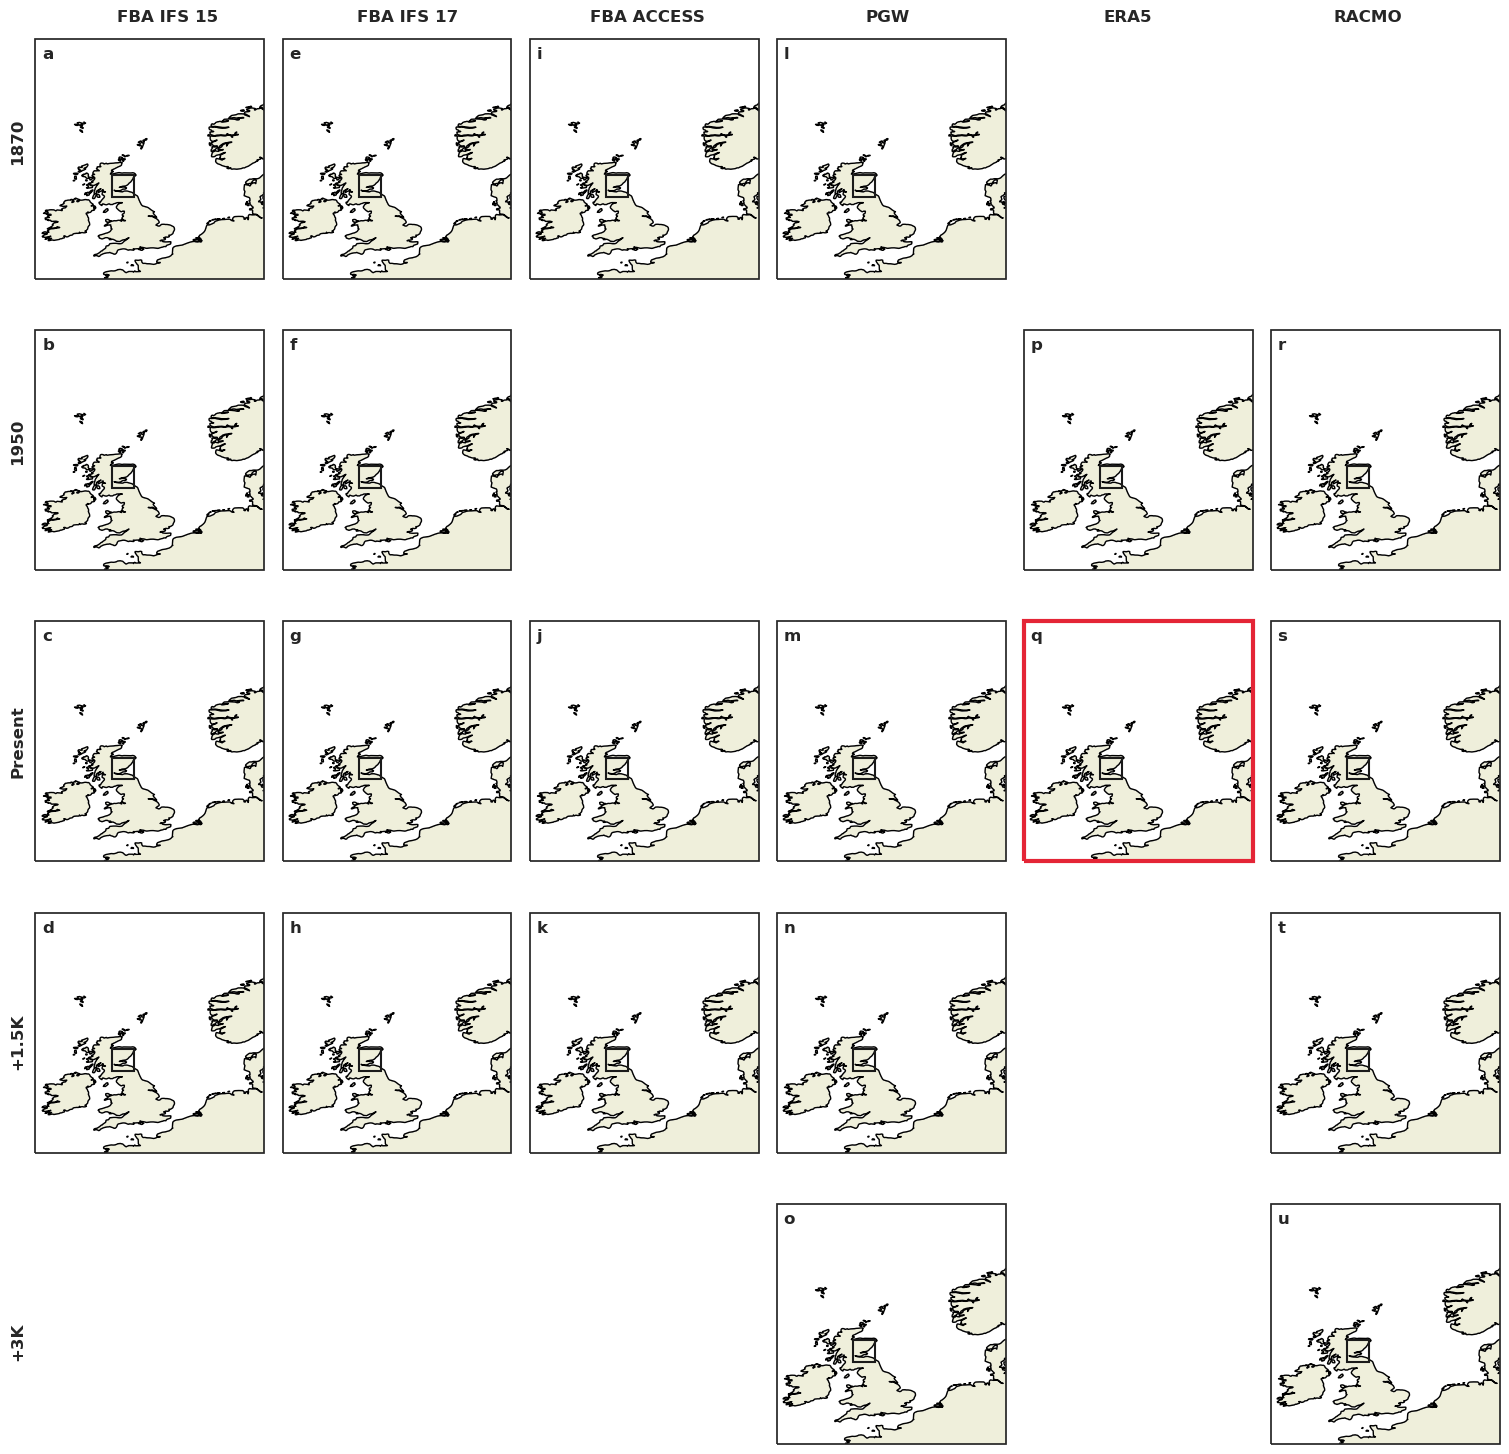

In [39]:
# Create figure with two subplots side by side
fig, axes = plt.subplots(ncols=6, nrows=5, figsize=(15, 15), subplot_kw={'projection': ccrs.PlateCarree()})

# Define column headers
column_headers = ["FBA IFS 15", "FBA IFS 17", "FBA ACCESS", "PGW", "ERA5", "RACMO"]

# FBA IFS 15 --------------

# data.plot.contourf(
#     cmap=cm.broc_r, vmin=-7, vmax=7,
#     levels=20, ax=axes[0, 0], add_colorbar=False  
# )
axes[4,0].axis('off')

# FBA IFS 17 --------------

axes[4,1].axis('off')

# FBA ACCESS --------------

axes[1,2].axis('off')
axes[4,2].axis('off')

# PGW ---------------------

axes[1,3].axis('off')

# ERA5 --------------------

axes[0,4].axis('off')
axes[3,4].axis('off')
axes[4,4].axis('off')

# Make ERA5 current plot stand out
axes[2,4].outline_patch.set_linewidth(3)  # Make frame bold
axes[2,4].outline_patch.set_edgecolor(color_palette[2])  # Set frame color to red

# RACMO -------------------

axes[0,5].axis('off')


# Figure settings ----------

labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u']
axes_with_data = [axes[0,0], axes[1,0], axes[2,0], axes[3,0], # FBA IFS 15
                  axes[0,1], axes[1,1], axes[2,1], axes[3,1], # FBA IFS 17
                  axes[0,2], axes[2,2], axes[3,2], # FBA ACCESS
                  axes[0,3], axes[2,3], axes[3,3], axes[4,3], # PGW
                  axes[1,4], axes[2,4], # ERA5
                  axes[1,5], axes[2,5], axes[3,5], axes[4,5], # RACMO

]

# Apply Cartopy settings to both axes
for ax, label in zip(axes_with_data, labels):
    ax.set_extent(uk, crs=ccrs.PlateCarree())  # Set map extent
    ax.add_feature(cfeature.LAND, edgecolor='black', linewidth=0.8)  # Add land borders
    ax.add_feature(cfeature.OCEAN, facecolor='white')  # Mask ocean
    ax.coastlines()  # Add coastlines
    ax.text(0.03, 0.92, label, transform=ax.transAxes, fontsize=12, fontweight="bold")

    rectangle = patches.Rectangle((-4, 55.5), 2, 2, linewidth=1.5, 
                                edgecolor='k', 
                                facecolor='none',
                                transform=ccrs.PlateCarree())
    ax.add_patch(rectangle)
    rectangle.set_zorder(17)

# Add column headers
col_locs = np.linspace(0.1, 0.9, len(column_headers))
for col_idx, col_name in enumerate(column_headers):
    fig.text(col_locs[col_idx], 0.98, col_name, fontsize=12, ha='center',  fontweight='bold')

# Define row headers
row_headers = ["1870", "1950", "Present", "+1.5K", "+3K"]

# Add row headers rotated by 90 degrees
for i, label in enumerate(row_headers):
    fig.text(0.00, 1 - (i + 0.5) / 5, label, va='center', ha='center', 
             fontsize=12, rotation=90, fontweight='bold')

plt.tight_layout()